In [ ]:
!pip install gymnasium numpy matplotlib tqdm

In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.1 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399000 sha256=19a526ede324b11c4d8449fe8c5f5a535d7abc1d46011a4d2694504e4e2c7de9
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
# Pygame first avoids some resolver pinning hiccups
!pip -q install "pygame>=2.5.2"

# Install the Box2D extra (pulls box2d-py) AFTER swig is present
#!pip -q install "gymnasium[box2d]"

# RL libs
!pip -q install "stable-baselines3[extra]" sb3-contrib tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym, Box2D, pygame, stable_baselines3 as sb3
print("Gymnasium:", gym.__version__)
print("SB3:", sb3.__version__)
print("Box2D OK:", hasattr(Box2D, "__version__"))
print("CarRacing make:", gym.make("CarRacing-v3", continuous=True))


Gymnasium: 1.2.2
SB3: 2.7.0
Box2D OK: True
CarRacing make: <TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v3>>>>>


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import sys, torch, gymnasium as gym, stable_baselines3 as sb3
print("Python:", sys.version.split()[0])
print("Gymnasium:", gym.__version__, "SB3:", sb3.__version__, "PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: 3.12.12
Gymnasium: 1.2.2 SB3: 2.7.0 PyTorch: 2.8.0+cu126
CUDA available: True


In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack

ENV_ID = "CarRacing-v3"

# Vectorized env + wrappers for pixel-based CNN policies
venv = make_vec_env(
    ENV_ID, n_envs=4, seed=0,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95)  # continuous controls for SAC
)
venv = VecTransposeImage(venv)        # HWC → CHW for PyTorch
venv = VecFrameStack(venv, n_stack=4) # 4-frame stack for short memory from pixels

model = SAC("CnnPolicy", venv, verbose=1, tensorboard_log="./tb/sac_car")
model.learn(total_timesteps=20000)  # start small; increase to 1e6+ when you're ready
model.save("sac_car")
venv.close()


Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 221.20GB > 86.89GB
  warnings.warn(


Logging to ./tb/sac_car/SAC_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -35.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 40       |
|    time_elapsed    | 99       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -8.05    |
|    critic_loss     | 0.176    |
|    ent_coef        | 0.747    |
|    ent_coef_loss   | -1.47    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -36.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 39       |
|    time_elapsed    | 200      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -13      |
|    critic_loss     | 0.373    |
|    ent_coef 

In [ ]:
# === VIDEO of one episode (deterministic) — FIXED ===
import glob, torch
from IPython.display import HTML
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecVideoRecorder

ENV_ID = "CarRacing-v3"
MODEL_PATH = "sac_car"  # or "./models/sac_best/best_model.zip"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build eval env with SAME wrappers as training, but enable frame rendering for video:
eval_env = make_vec_env(
    ENV_ID,
    n_envs=1,
    seed=999,
    env_kwargs=dict(
        continuous=True,
        lap_complete_percent=0.95,
        render_mode="rgb_array"   # <-- REQUIRED for VecVideoRecorder
    ),
)
eval_env = VecTransposeImage(eval_env)        # HWC -> CHW
eval_env = VecFrameStack(eval_env, n_stack=4) # 4 stacked frames -> 12 channels

# Attach a video recorder (records the very first episode)
video_env = VecVideoRecorder(
    eval_env,
    video_folder="videos",
    record_video_trigger=lambda step: step == 0,
    video_length=10_000,             # max frames to record
    name_prefix="sac_carracing"
)

# Load model and bind to the recorder env (also shrink buffer for eval-only)
model = SAC.load(
    MODEL_PATH,
    env=video_env,
    device=device,
    custom_objects={"buffer_size": 100_000}
)

# Roll one episode deterministically
obs = video_env.reset()
while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = video_env.step(action)
    if dones[0]:
        break

# Close and display
video_env.close()

# Show the latest MP4 inline
vids = sorted(glob.glob("videos/*.mp4"))
print("Saved video:", vids[-1])
HTML(f'<video controls width="640"><source src="{vids[-1]}" type="video/mp4"></video>')


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/sac_carracing-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/sac_carracing-step-0-to-step-10000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/videos/sac_carracing-step-0-to-step-10000.mp4
Saved video: videos/sac_carracing-step-0-to-step-10000.mp4


In [ ]:
from google.colab import drive; drive.mount('/content/drive')
!cp -v videos/*.mp4 /content/drive/MyDrive/


Mounted at /content/drive
'videos/sac_carracing-step-0-to-step-10000.mp4' -> '/content/drive/MyDrive/sac_carracing-step-0-to-step-10000.mp4'


,seed,reward,steps
0,1001,-32.692308,1000
1,1002,-23.636366,1000
2,1003,-33.333335,1000
3,1004,0.671138,1000
4,1005,-7.975460,1000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mean reward: -19.39326609224081 ± 15.183383182566889


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


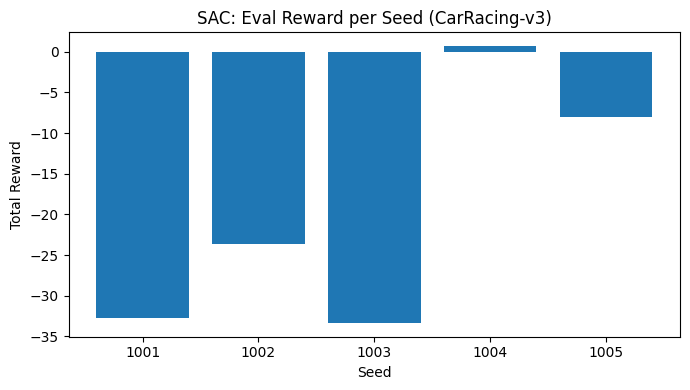

Saved: sac_eval_rewards.png and sac_eval_rewards.csv


In [ ]:
# === BASIC GRAPH of eval rewards across seeds ===
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack

ENV_ID   = "CarRacing-v3"
MODEL    = "sac_car"  # or "models/sac_best/best_model.zip"
SEEDS    = [1001, 1002, 1003, 1004, 1005]
MAX_STEPS = 3000

def make_eval_env(seed):
    env = make_vec_env(
        ENV_ID, n_envs=1, seed=seed,
        env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
    )
    env = VecTransposeImage(env)
    env = VecFrameStack(env, n_stack=4)
    return env

rows = []
for s in SEEDS:
    env = make_eval_env(s)
    model = SAC.load(MODEL, env=env, device="cuda" if torch.cuda.is_available() else "cpu",
                     custom_objects={"buffer_size": 100_000})
    obs = env.reset()
    total, steps = 0.0, 0
    for t in range(MAX_STEPS):
        a, _ = model.predict(obs, deterministic=True)
        obs, r, dones, infos = env.step(a)
        total += float(r[0]); steps += 1
        if dones[0]:
            break
    rows.append({"seed": s, "reward": total, "steps": steps})
    env.close()

df = pd.DataFrame(rows)
display(df)
print("Mean reward:", df["reward"].mean(), "±", df["reward"].std())

# Bar chart
plt.figure(figsize=(7,4))
plt.bar(df["seed"].astype(str), df["reward"])
plt.title("SAC: Eval Reward per Seed (CarRacing-v3)")
plt.xlabel("Seed"); plt.ylabel("Total Reward")
plt.tight_layout()
plt.savefig("sac_eval_rewards.png", dpi=150)
plt.show()

# Save CSV too
df.to_csv("sac_eval_rewards.csv", index=False)
print("Saved: sac_eval_rewards.png and sac_eval_rewards.csv")


In [ ]:
import torch
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, StopTrainingOnNoModelImprovement

ENV_ID = "CarRacing-v3"

# ------- TRAIN ENV (parallel) -------
train_env = make_vec_env(
    ENV_ID, n_envs=4, seed=0,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
train_env = VecTransposeImage(train_env)
train_env = VecFrameStack(train_env, n_stack=4)
train_env = VecMonitor(train_env)  # episode stats in infos

# ------- EVAL ENV (single) -------
eval_env = make_vec_env(
    ENV_ID, n_envs=1, seed=123,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=4)
eval_env = VecMonitor(eval_env)

# ------- CALLBACKS -------
stop_cb = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=10, min_evals=10, verbose=1
)
eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./models/sac_best",
    log_path="./logs/sac_eval",
    eval_freq=100_000,            # evaluate every 100k steps
    n_eval_episodes=3,
    deterministic=True,
    callback_after_eval=stop_cb
)
ckpt_cb = CheckpointCallback(save_freq=200_000, save_path="./models/sac_ckpts", name_prefix="sac")

# ------- MODEL -------
model = SAC(
    "CnnPolicy",
    train_env,
    verbose=1,
    tensorboard_log="./tb/sac_car",
    learning_rate=3e-4,
    buffer_size=300_000,          # smaller than default to reduce RAM
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto"
)

model.learn(total_timesteps=1000000, callback=[eval_cb, ckpt_cb])
model.save("sac_car_1M")
train_env.close(); eval_env.close()


Using cuda device
Logging to ./tb/sac_car/SAC_4


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 66.36GB > 57.54GB
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -36.1    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 42       |
|    time_elapsed    | 93       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -8.23    |
|    critic_loss     | 0.227    |
|    ent_coef        | 0.747    |
|    ent_coef_loss   | -1.47    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -36.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 42       |
|    time_elapsed    | 189      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -12.6    |
|    critic_loss     | 0.102    |
|    ent_coef 

KeyboardInterrupt: 

In [ ]:
import torch, numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecMonitor

ENV_ID = "CarRacing-v3"
MODEL_PATH = "./models/sac_best/best_model.zip"  # or "sac_car_1M.zip"

eval_env = make_vec_env(
    ENV_ID, n_envs=1, seed=999,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=4)
eval_env = VecMonitor(eval_env)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SAC.load(MODEL_PATH, env=eval_env, device=device, custom_objects={"buffer_size": 100_000})

MAX_STEPS = 3000
obs = eval_env.reset()
ep_reward = 0.0
terminated_cause = "unknown"

with torch.inference_mode():
    for t in range(MAX_STEPS):
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = eval_env.step(action)
        ep_reward += float(rewards[0])
        if dones[0]:
            # SB3/Monitor puts 'episode' summary in info when episode ends
            info = infos[0]
            if info.get("terminal_observation") is not None:
                # TimeLimit truncation path often fills this; also check key:
                terminated_cause = "time_limit" if info.get("TimeLimit.truncated", False) else "terminated"
            else:
                terminated_cause = "terminated"
            break

print(f"SAC episode reward: {ep_reward:.2f} | steps: {t+1} | end: {terminated_cause}")
eval_env.close()


Graph between rewards and total time steps

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt

EVAL_NPZ = "./logs/sac_eval/evaluations.npz"
assert os.path.exists(EVAL_NPZ), f"Missing {EVAL_NPZ}. Make sure EvalCallback ran."

data = np.load(EVAL_NPZ)
timesteps = data["timesteps"]          # shape (n_eval_points,)
results   = data["results"]            # shape (n_eval_points, n_eval_episodes)

means = results.mean(axis=1)
stds  = results.std(axis=1)

plt.figure(figsize=(7,4))
plt.plot(timesteps, means, label="Eval mean return")
plt.fill_between(timesteps, means - stds, means + stds, alpha=0.3, label="±1 std")
plt.xlabel("Timesteps")
plt.ylabel("Episode return")
plt.title("SAC on CarRacing-v3 — Evaluation reward vs. timesteps")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("sac_eval_return_vs_timesteps.png", dpi=150)
plt.show()

print("Saved: sac_eval_return_vs_timesteps.png")


**Continuous Mode, seed=42 (random actions)**

Step 000 | reward= +6.967 | total=  +6.967
Step 020 | reward= -0.100 | total=  +4.967
Step 040 | reward= -0.100 | total=  +6.501
Step 060 | reward= -0.100 | total=  +4.501
Step 080 | reward= -0.100 | total=  +6.034
Step 100 | reward= -0.100 | total=  +4.034
Step 120 | reward= -0.100 | total=  +2.034
Step 140 | reward= -0.100 | total=  +3.568
Step 160 | reward= -0.100 | total=  +1.568
Step 180 | reward= -0.100 | total=  -0.432
Step 200 | reward= -0.100 | total=  +1.101
Step 220 | reward= -0.100 | total=  -0.899
Step 240 | reward= -0.100 | total=  -2.899
Step 260 | reward= -0.100 | total=  -1.365
Step 280 | reward= -0.100 | total=  -3.365
Step 300 | reward= -0.100 | total=  -5.365
Step 320 | reward= -0.100 | total=  -3.831
Step 340 | reward= -0.100 | total=  -5.831
Step 360 | reward= -0.100 | total=  -7.831
Step 380 | reward= -0.100 | total=  -6.298
Step 400 | reward= -0.100 | total=  -8.298
Step 420 | reward= -0.100 | total= -10.298
Step 440 | reward= -0.100 | total=  -8.764
Step 460 | 

Video saved to: car_racing1.mp4


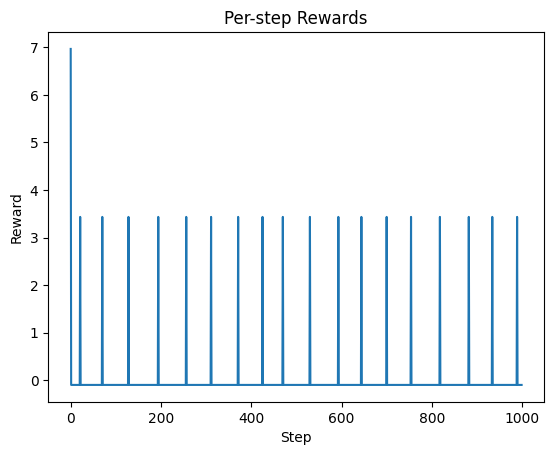

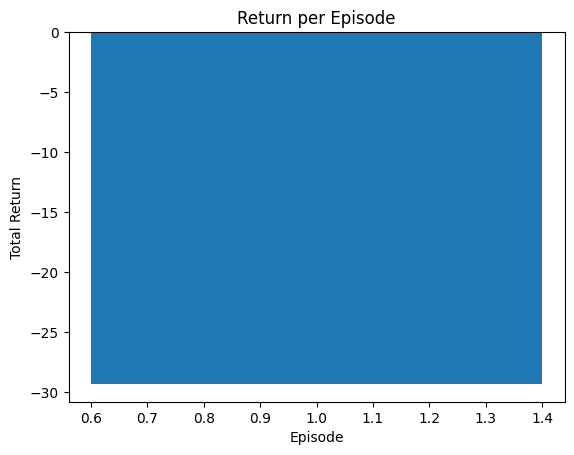

Episodes: 1
Mean return: -29.33 | Best: -29.33 | Worst: -29.33
Steps per episode: [1000]


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import imageio
from IPython.display import Video

# Initialize the environment
env = gym.make("CarRacing-v3", render_mode="rgb_array_list")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

frames = []
rewards = []              # Per step rewards across the whole run
episode_returns = []      # Total reward per episode
steps_per_episode = []    # Number of steps per episode

episode_return = 0.0
ep_steps = 0

MAX_STEPS = 1000
for t in range(MAX_STEPS):
    action = env.action_space.sample()

    # Step (transition) through the environment with the action
    observation, reward, terminated, truncated, info = env.step(action)
    frames.extend(env.render())

    # Record rewards
    rewards.append(reward)
    episode_return += reward
    ep_steps += 1

    if t % 20 == 0:
        print(f"Step {t:03d} | reward={reward:+7.3f} | total={episode_return:+8.3f}")

    # If the episode has ended, log and reset
    if terminated or truncated:
        episode_returns.append(episode_return)
        steps_per_episode.append(ep_steps)

        episode_return = 0.0
        ep_steps = 0

        observation, info = env.reset()

# If loop ended mid-episode, log that too
if ep_steps > 0:
    episode_returns.append(episode_return)
    steps_per_episode.append(ep_steps)

env.close()

video_path = "car_racing1.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"Video saved to: {video_path}")

Video(video_path, embed=True)

# Plotting of rewards
plt.figure()
plt.plot(rewards)
plt.title("Per-step Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

plt.figure()
plt.bar(range(1, len(episode_returns) + 1), episode_returns)
plt.title("Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.show()

print(f"Episodes: {len(episode_returns)}")
if episode_returns:
    print(f"Mean return: {sum(episode_returns)/len(episode_returns):.2f} | "
          f"Best: {max(episode_returns):.2f} | Worst: {min(episode_returns):.2f}")
    print(f"Steps per episode: {steps_per_episode}")


**Continuous, seed=0**

Obs shape: (96, 96, 3)
Obs space: Box(0, 255, (96, 96, 3), uint8)
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Step 000 | reward= +6.170 | total=  +6.170
Step 020 | reward= -0.100 | total=  +4.170
Step 040 | reward= -0.100 | total=  +5.304
Step 060 | reward= -0.100 | total=  +3.304
Step 080 | reward= -0.100 | total=  +4.439
Step 100 | reward= -0.100 | total=  +2.439
Step 120 | reward= -0.100 | total=  +0.439
Step 140 | reward= -0.100 | total=  +1.574
Step 160 | reward= -0.100 | total=  -0.426
Step 180 | reward= -0.100 | total=  -2.426
Step 200 | reward= -0.100 | total=  -1.291
Step 220 | reward= -0.100 | total=  -3.291
Step 240 | reward= -0.100 | total=  -5.291
Step 260 | reward= -0.100 | total=  -4.156
Step 280 | reward= -0.100 | total=  -6.156
Step 300 | reward= -0.100 | total=  -8.156
Step 320 | reward= -0.100 | total= -10.156
Step 340 | reward= -0.100 | total=  -9.022
Step 360 | reward= -0.100 | total= -11.022
Step 380 | reward= -0.100 | total= -13.022
Step 400 | reward= -0

Episode ended early.
Video saved to: car_racing2.mp4


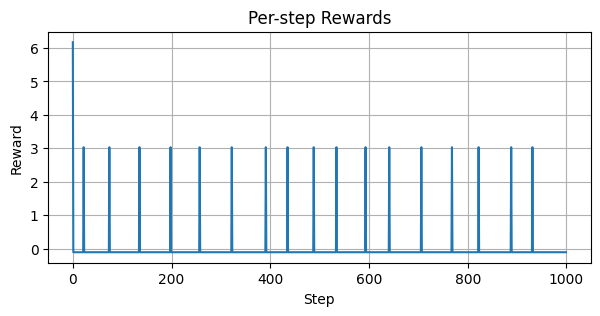

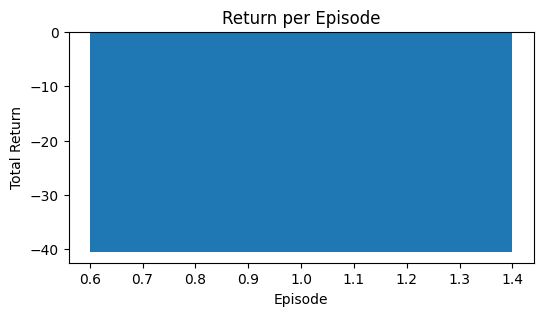

Episodes: 1
Mean return: -40.44 | Best: -40.44 | Worst: -40.44
Steps per episode: [1000]


In [ ]:
import gymnasium as gym
import numpy as np
import imageio
import matplotlib.pyplot as plt
from IPython.display import Video

# Initialize the environment
env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=True)

# Reset the environment
obs, info = env.reset(seed=0)
print("Obs shape:", obs.shape)
print("Obs space:", env.observation_space)
print("Action space:", env.action_space)

frames = []
rewards = []             # Per-step rewards
episode_returns = []     # Total reward per episode
steps_per_episode = []   # Number of steps per episode
episode_return = 0.0
ep_steps = 0

MAX_STEPS = 1000

for t in range(MAX_STEPS):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # Record per-step reward
    rewards.append(reward)
    episode_return += reward
    ep_steps += 1

    # Collect frame
    frame = env.render()
    frames.append(frame)

    if t % 20 == 0:
        print(f"Step {t:03d} | reward={reward:+7.3f} | total={episode_return:+8.3f}")

    if terminated or truncated:
        print("Episode ended early.")
        episode_returns.append(episode_return)
        steps_per_episode.append(ep_steps)
        # Reset episode trackers
        episode_return = 0.0
        ep_steps = 0
        obs, info = env.reset()

# Handle partial episode at end
if ep_steps > 0:
    episode_returns.append(episode_return)
    steps_per_episode.append(ep_steps)

env.close()

# Save video
video_path = "car_racing2.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"Video saved to: {video_path}")

# Display video inline
Video(video_path, embed=True)

# Plot per-step rewards
plt.figure(figsize=(7, 3))
plt.plot(rewards)
plt.title("Per-step Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Return per episode
plt.figure(figsize=(6, 3))
plt.bar(range(1, len(episode_returns) + 1), episode_returns)
plt.title("Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.show()

# Statistics
print(f"Episodes: {len(episode_returns)}")
if episode_returns:
    print(f"Mean return: {np.mean(episode_returns):.2f} | "
          f"Best: {np.max(episode_returns):.2f} | Worst: {np.min(episode_returns):.2f}")
    print(f"Steps per episode: {steps_per_episode}")


**Discrete, seed=0, Action: forward --> left --> right --> repeat**

Step 000 | reward= +6.170 | running ep return=  +6.170
Step 020 | reward= -0.100 | running ep return=  +7.304
Step 040 | reward= -0.100 | running ep return= +14.709
Step 060 | reward= -0.100 | running ep return= +22.113
Step 080 | reward= -0.100 | running ep return= +29.518
Step 100 | reward= -0.100 | running ep return= +27.518
Step 120 | reward= -0.100 | running ep return= +25.518
Step 140 | reward= -0.100 | running ep return= +23.518
Step 160 | reward= -0.100 | running ep return= +21.518
Step 180 | reward= -0.100 | running ep return= +19.518
Step 200 | reward= -0.100 | running ep return= +17.518
Step 220 | reward= -0.100 | running ep return= +15.518
Step 240 | reward= -0.100 | running ep return= +13.518
Step 260 | reward= -0.100 | running ep return= +11.518
Step 280 | reward= -0.100 | running ep return=  +9.518
Step 300 | reward= -0.100 | running ep return=  +7.518
Step 320 | reward= -0.100 | running ep return=  +5.518
Step 340 | reward= -0.100 | running ep return=  +3.518
Step 360 |

Episode ended → return=-12.23, steps=1000

Video saved to: car_racing3.mp4


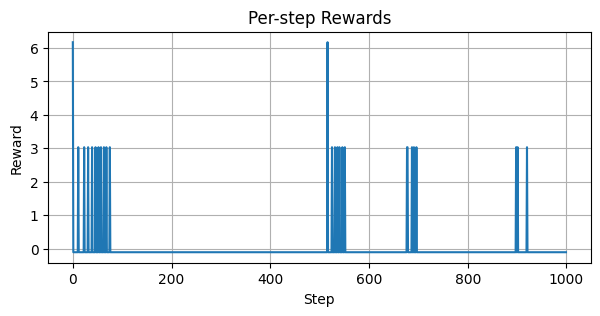

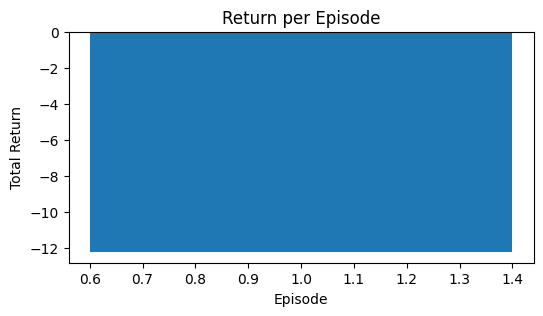

Episodes: 1
Mean return: -12.23 | Best: -12.23 | Worst: -12.23
Steps per episode: [1000]


In [ ]:
import gymnasium as gym
import imageio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

# Initialize environment
env = gym.make("CarRacing-v3", render_mode="rgb_array_list", continuous=False)

# Reset environment
obs, info = env.reset(seed=0)

frames = []

# Reward tracking
rewards = []             # Per step rewards across the whole run
episode_returns = []     # Total reward per episode
steps_per_episode = []   # Steps taken in each episode
episode_return = 0.0
ep_steps = 0

total_steps = 1000
for t in range(total_steps):
    # Pattern: gas forward, then left, then right, repeat
    phase = (t // 60) % 3
    if phase == 0:
        action = 3  # gas
    elif phase == 1:
        action = 2  # steer left
    else:
        action = 1  # steer right

    obs, reward, terminated, truncated, info = env.step(action)

    # Track rewards
    rewards.append(reward)
    episode_return += reward
    ep_steps += 1

    # Collect any new frames since last step
    frames.extend(env.render())

    if (t % 20) == 0:
        print(f"Step {t:03d} | reward={reward:+7.3f} | running ep return={episode_return:+8.3f}")

    if terminated or truncated:
        episode_returns.append(episode_return)
        steps_per_episode.append(ep_steps)
        print(f"Episode ended → return={episode_return:.2f}, steps={ep_steps}")
        episode_return = 0.0
        ep_steps = 0
        obs, info = env.reset()

# If we ended mid-episode, log the partial ep too
if ep_steps > 0:
    episode_returns.append(episode_return)
    steps_per_episode.append(ep_steps)

env.close()

# Save video
video_path = "car_racing3.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"\nVideo saved to: {video_path}")

Video(video_path, embed=True)

# Per-step rewards
plt.figure(figsize=(7, 3))
plt.plot(rewards)
plt.title("Per-step Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Return per episode
plt.figure(figsize=(6, 3))
plt.bar(range(1, len(episode_returns) + 1), episode_returns)
plt.title("Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.show()

# Summary
print(f"Episodes: {len(episode_returns)}")
if episode_returns:
    print(
        f"Mean return: {np.mean(episode_returns):.2f} | "
        f"Best: {np.max(episode_returns):.2f} | "
        f"Worst: {np.min(episode_returns):.2f}"
    )
    print(f"Steps per episode: {steps_per_episode}")


**Discrete, seed=42, Action: forward --> left --> right --> repeat**

Step 000 | reward= +6.967 | running ep return=  +6.967
Step 020 | reward= -0.100 | running ep return=  +8.501
Step 040 | reward= -0.100 | running ep return= +17.101
Step 060 | reward= -0.100 | running ep return= +25.702
Step 080 | reward= -0.100 | running ep return= +34.303
Step 100 | reward= -0.100 | running ep return= +32.303
Step 120 | reward= -0.100 | running ep return= +30.303
Step 140 | reward= -0.100 | running ep return= +28.303
Step 160 | reward= -0.100 | running ep return= +26.303
Step 180 | reward= -0.100 | running ep return= +24.303
Step 200 | reward= -0.100 | running ep return= +22.303
Step 220 | reward= -0.100 | running ep return= +20.303
Step 240 | reward= -0.100 | running ep return= +18.303
Step 260 | reward= -0.100 | running ep return= +16.303
Step 280 | reward= -0.100 | running ep return= +14.303
Step 300 | reward= -0.100 | running ep return= +12.303
Step 320 | reward= -0.100 | running ep return= +10.303
Step 340 | reward= -0.100 | running ep return=  +8.303
Step 360 |

Episode ended → return=6.01, steps=1000

Video saved to: car_racing4.mp4


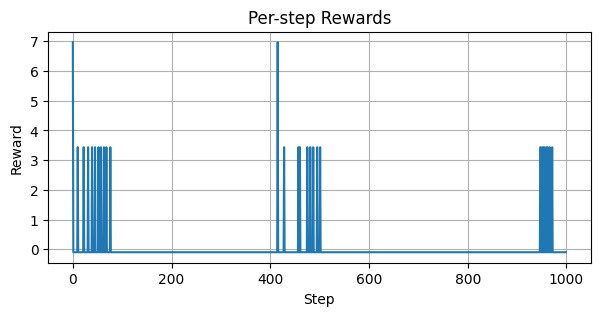

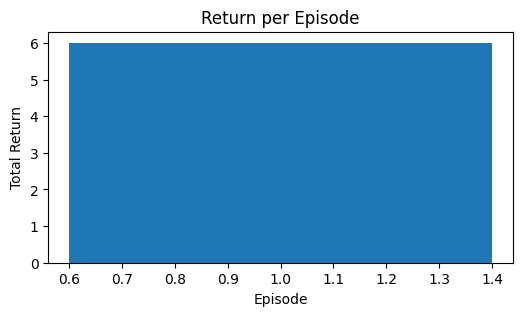

Episodes: 1
Mean return: 6.01 | Best: 6.01 | Worst: 6.01
Steps per episode: [1000]


In [ ]:
import gymnasium as gym
import imageio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

# Initialize environment
env = gym.make("CarRacing-v3", render_mode="rgb_array_list", continuous=False)

# Reset environment
obs, info = env.reset(seed=42)

frames = []

# Reward tracking
rewards = []             # Per step rewards across the whole run
episode_returns = []     # Total reward per episode
steps_per_episode = []   # Steps taken in each episode
episode_return = 0.0
ep_steps = 0

total_steps = 1000
for t in range(total_steps):
    # Pattern: gas forward, then left, then right, repeat
    phase = (t // 60) % 3
    if phase == 0:
        action = 3  # gas
    elif phase == 1:
        action = 2  # steer left
    else:
        action = 1  # steer right

    obs, reward, terminated, truncated, info = env.step(action)

    # Track rewards
    rewards.append(reward)
    episode_return += reward
    ep_steps += 1

    # Collect any new frames since last step
    frames.extend(env.render())

    if (t % 20) == 0:
        print(f"Step {t:03d} | reward={reward:+7.3f} | running ep return={episode_return:+8.3f}")

    if terminated or truncated:
        episode_returns.append(episode_return)
        steps_per_episode.append(ep_steps)
        print(f"Episode ended → return={episode_return:.2f}, steps={ep_steps}")
        episode_return = 0.0
        ep_steps = 0
        obs, info = env.reset()

# If we ended mid-episode, log the partial ep too
if ep_steps > 0:
    episode_returns.append(episode_return)
    steps_per_episode.append(ep_steps)

env.close()

# Save video
video_path = "car_racing4.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"\nVideo saved to: {video_path}")

Video(video_path, embed=True)

# Per-step rewards
plt.figure(figsize=(7, 3))
plt.plot(rewards)
plt.title("Per-step Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Return per episode
plt.figure(figsize=(6, 3))
plt.bar(range(1, len(episode_returns) + 1), episode_returns)
plt.title("Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.show()

# Summary
print(f"Episodes: {len(episode_returns)}")
if episode_returns:
    print(
        f"Mean return: {np.mean(episode_returns):.2f} | "
        f"Best: {np.max(episode_returns):.2f} | "
        f"Worst: {np.min(episode_returns):.2f}"
    )
    print(f"Steps per episode: {steps_per_episode}")
